In [1]:
import poliastro as PA
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from poliastro.bodies import Earth, Body
from poliastro.twobody import Orbit
from poliastro.examples import iss

from scipy.stats import expon, uniform, norm, triang

In [3]:
# Exponential Distribution
size = 100

J_1 = expon.rvs(scale=1, loc=0.0, size=size)

exponential_var2 = expon.rvs(scale=0.01, loc=0, size=size)
J_2 = J_1 - exponential_var2

for i in range(0,size):
    if J_2[i] < 0.0:
        J_2[i] = 0.0001

exponential_var3 = expon.rvs(scale=0.1, loc=0, size=size)
J_3 = J_2 - exponential_var3

for i in range(0,size):
    if J_3[i] < -J_2[i]:
        J_3[i] = -J_2[i]

M = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad
w = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad
Omega = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad

In [177]:
# Near Circular Distribution
size = 500
r_0 = 1*u.km
sigma_e = 0.01*np.sqrt(1*u.km)
sigma_a = 0.000*np.sqrt(1*u.km)
alpha_over_m = 1*u.km**3/u.s**2 


expvar1 = expon.rvs(scale=sigma_e, loc=0, size=size)*np.sqrt(1*u.km)

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = expvar1 + J_2
J_3 = J_2

M = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [244]:
# Near Gausian in R Distribution
size = 500
r_0 = 1*u.km
sigma_r = 0.5*u.kg*u.km**2
alpha_over_m = 1*u.km**3/u.s**2 


expvar1 = expon.rvs(scale=1, loc=0, size=size)

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = np.sqrt((np.power(J_2, 2) + np.sqrt(np.power(J_2, 4) + sigma_r*expvar1))/2.0)
J_3 = J_2

M = uniform.rvs(loc = -2*np.pi, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [362]:
# Near SHO Distribution
# Here I'm setting J_SHO = sqrt(ma^3/2k) * (p^2/2m + k/a^3*x^2)
# This leads to J_SHO = sqrt(ka/2)e^2 = sqrt(k/2)(J_1 - J_2^2/J_1)
# Then im distributing particles according to exp{- J_SHO/epsilon}

size = 100
r_0 = 1*u.km
epsilon = 0.001*u.kg*u.km**2/u.s
k = 1*u.kg*u.km**3/u.s**2 
m = 0.1*u.kg

J_SHO = expon.rvs(scale=epsilon, loc=0, size=size)*1*u.kg*u.km**2/u.s

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = (J_SHO + np.sqrt(np.power(J_SHO, 2) + 4*k*m*np.power(J_2, 2)))/(2.0*np.sqrt(k*m))
J_3 = J_2

M = uniform.rvs(loc = -2*np.pi, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [363]:
omega = np.sqrt(k/m)/np.power(r_0, 3.0/2.0)
omega_prime = -3/(2*m*np.power(r_0, 2.0))
print("Omega_0: ", omega)
print("Omega_prime: ", omega_prime)
print("Decoherance Time: ", 2*np.pi/(omega_prime*epsilon))

average_radius = 3*sigma_e**2 + 3*sigma_e*sigma_a + 3*sigma_e*np.sqrt(r_0) + 2*sigma_a**2 + 2*sigma_a*np.sqrt(r_0) + r_0
print("Inital average radius: ", average_radius)

Omega_0:  3.1622776601683795 1 / s
Omega_prime:  -15.0 1 / (kg km2)
Decoherance Time:  -418.8790204786391 s
Inital average radius:  1.0303 km


In [364]:
a = np.square(J_1)
ecc = np.sqrt(1 - np.square(J_2/J_1)) * u.one
inc = np.arccos(J_3/J_2)

GM = Body(None, alpha_over_m, "Central Body")

In [365]:
orb = [None]*size
for i in range(0, size):
    orb[i] = Orbit.from_classical(GM, a[i], ecc[i], inc[i], Omega[i], w[i], M[i])

C:\Users\henhe\anaconda3\lib\site-packages\astropy\units\decorators.py:252: UserWarning: Wrapping true anomaly to -π <= nu < π
  return_ = wrapped_function(*func_args, **func_kwargs)


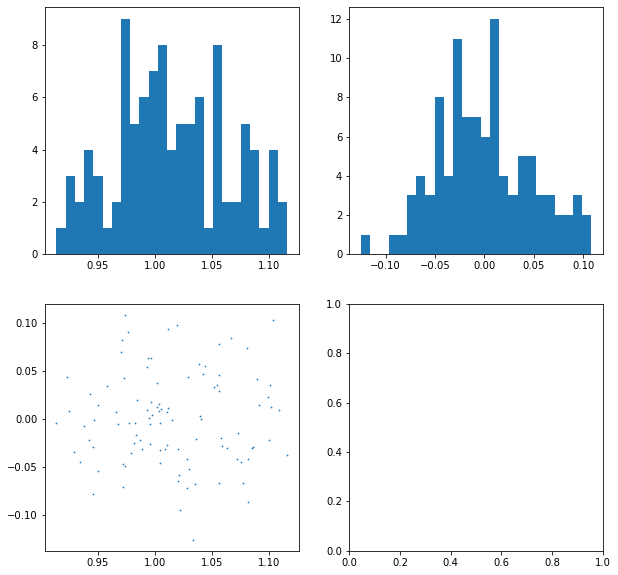

In [380]:
r = np.zeros(size)
p = np.zeros(size)

for i in range(0, size):
    r[i] = np.linalg.norm(orb[i].r)/(1*u.km)
    unit_r = orb[i].r/(r[i]*u.km)
    p[i] = np.dot(unit_r, orb[i].v*u.second/u.km)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 10))
ax1.hist(r, bins=25)
ax2.hist(p, bins=25)
ax3.scatter(r, p, s=0.5)

(array([4., 2., 3., 5., 3., 6., 2., 3., 6., 4., 3., 0., 4., 7., 0., 5., 6.,
        6., 7., 3., 4., 5., 5., 3., 4.]),
 array([-3.13278987, -2.8850605 , -2.63733113, -2.38960176, -2.14187239,
        -1.89414301, -1.64641364, -1.39868427, -1.1509549 , -0.90322553,
        -0.65549616, -0.40776679, -0.16003742,  0.08769195,  0.33542132,
         0.58315069,  0.83088006,  1.07860943,  1.3263388 ,  1.57406817,
         1.82179754,  2.06952691,  2.31725628,  2.56498565,  2.81271502,
         3.06044439]),
 <BarContainer object of 25 artists>)

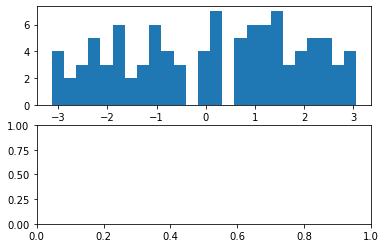

In [367]:
nu = np.zeros(size)

for i in range(0, size):
    nu[i] = orb[i].nu/u.rad
fig, (ax1, ax2) = plt.subplots(2)
ax1.hist(nu, bins=25)

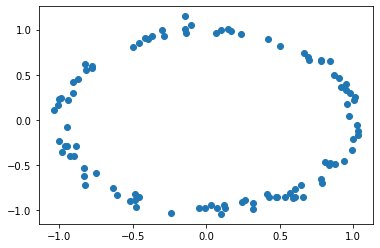

In [368]:
x = np.empty(size)*u.km
y = np.empty(size)*u.km
for i in range(0, size):
    x[i] = orb[i].r[0]
    y[i] = orb[i].r[1]
    
plt.scatter(x, y)

In [369]:
timestep = 10*u.second

time_before_kick = 100*u.second
time_after_kick = 1500*u.second
time_after_quad_kick = 2000*u.second

steps_before_kick = int(time_before_kick/timestep)
steps_after_kick = int(time_after_kick/timestep)
steps_after_quad_kick = int(time_after_quad_kick/timestep)

total_time = time_before_kick + time_after_kick + time_after_quad_kick
total_steps = steps_before_kick + steps_after_kick + steps_after_quad_kick

time = np.linspace(0.0*u.second, total_time, total_steps)

avr_radius = np.zeros(total_steps) * u.km

radiuses = np.zeros((size, total_steps, 3)) * u.km
velocities = np.zeros((size, total_steps, 3)) * u.km/u.second


In [370]:
time_array = np.linspace(0.0, time_before_kick, steps_before_kick)
for particle in range(0, size):
    
    radiuses[particle][0:steps_before_kick], velocities[particle][0:steps_before_kick] = PA.twobody.propagation.cowell(1 * u.km**3 / u.s**2, orb[particle].r, orb[particle].v, time_array)
    orb[particle] = orb[particle].propagate(time_before_kick)

In [371]:
for step in range(0, steps_before_kick):
    avr_radius[step] = sum(np.linalg.norm(radiuses[:,step], axis=1))/size

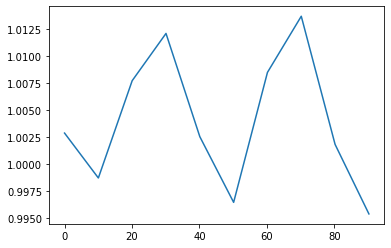

In [372]:
plt.plot(time[0:steps_before_kick], avr_radius[0:steps_before_kick])

In [373]:
unit_r = np.empty(3) 
newR = np.empty(3)

kickStrength = 0.05*u.km

for i in range(0, size):
        if orb[i].energy >= 0:
            print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
        old_radius = np.linalg.norm(orb[i].r)
        unit_r = orb[i].r/old_radius
        old_r_0 = orb[i].a*(1 - np.square(orb[i].ecc))
        newPosition = orb[i].r + kickStrength*unit_r
        oldThetaVelocity = orb[i].v - np.dot(orb[i].v, unit_r)*unit_r
        newThetaVelocity = old_radius/(old_radius + kickStrength)*oldThetaVelocity
        newVelocity = np.dot(orb[i].v, unit_r)*unit_r + newThetaVelocity
        orb[i] = Orbit.from_vectors(GM, newPosition, newVelocity)
        new_r_0 = orb[i].a*(1 - np.square(orb[i].ecc))
        if old_r_0 - new_r_0 > 10**-12*u.km:
            print("L_2 before and after do not match: ", old_r_0, "\t", new_r_0)
        if orb[i].energy >= 0:
            print(orb[i], " is not a bound orbit.")
        if (orb[i].r != newPosition).any():
            print("r got missassigned.")
#         if (np.linalg.norm(orb[i].r) > old_radius):
#             print("The new radius is greater than the original.", np.linalg.norm(orb[i].r), old_radius)
#             print(orb[i].r, old_radius)
#             print("Radius should be",np.linalg.norm(newPosition) )

In [374]:
for particle in range(0, size):
    radiuses[particle][steps_before_kick:steps_after_kick+steps_before_kick], velocities[particle][steps_before_kick:steps_after_kick+steps_before_kick] = PA.twobody.propagation.cowell(1 * u.km**3 / u.s**2, orb[particle].r, orb[particle].v, np.linspace(time_before_kick, time_after_kick, steps_after_kick))
    orb[particle] = orb[particle].propagate(time_after_kick)

In [375]:
for step in range(steps_before_kick, steps_before_kick+steps_after_kick):
    avr_radius[step] = sum(np.linalg.norm(radiuses[:,step], axis=1))/size

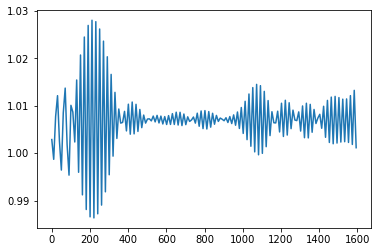

In [376]:
plt.plot(time[0:steps_before_kick+steps_after_kick], avr_radius[0:steps_before_kick+steps_after_kick])

In [377]:
unit_r = np.empty(3) 
newR = np.empty(3)

quad_strength = 0.01 * u.second**-1
radius_offset = r_0

for i in range(0, size):
        if orb[i].energy >= 0:
            print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
        old_radius = np.linalg.norm(orb[i].r)
        unit_r = orb[i].r/old_radius
        newVelocity = orb[i].v + quad_strength*(old_radius - radius_offset)*unit_r
        orb[i] = Orbit.from_vectors(GM, orb[i].r, newVelocity)
        if orb[i].energy >= 0:
            print(orb[i], " is not a bound orbit.")
#         if (np.linalg.norm(orb[i].r) > old_radius):
#             print("The new radius is greater than the original.", np.linalg.norm(orb[i].r), old_radius)
#             print(orb[i].r, old_radius)
#             print("Radius should be",np.linalg.norm(newPosition) )

In [378]:
for step in range(0, steps_after_quad_kick):
    for i in range(0, size):
        orb[i] = orb[i].propagate(timestep)
        avr_radius[step+steps_before_kick+steps_after_kick] = avr_radius[step+steps_before_kick+steps_after_kick] + np.linalg.norm(orb[i].r)
    avr_radius[step+steps_before_kick+steps_after_kick] = avr_radius[step+steps_before_kick+steps_after_kick]/size

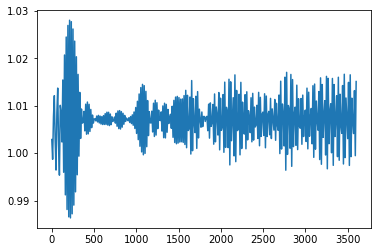

In [379]:
plt.plot(time[0:steps_before_kick+steps_after_kick+steps_after_quad_kick], avr_radius[0:steps_before_kick+steps_after_kick+steps_after_quad_kick])